# Bollinger Band Trading Strategy for Squid_Ink

This notebook implements a trading strategy based on Bollinger Bands and price spikes for Squid_Ink. The strategy buys when the price is below 2000 and sells when the price is above 2000, but only when there are significant price spikes detected by the rolling standard deviation.

In [2]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap, calculate_price_spikes, calculate_bollinger_bands
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import seaborn, but don't fail if it's not available
try:
    import seaborn as sns
    print(f"Seaborn version: {sns.__version__}")
    sns.set(style="whitegrid")
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not available, using matplotlib instead")
    HAS_SEABORN = False

Using backtester package
Seaborn version: 0.13.2


## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
VWAP range: 1832.0 to 2187.3880597014927


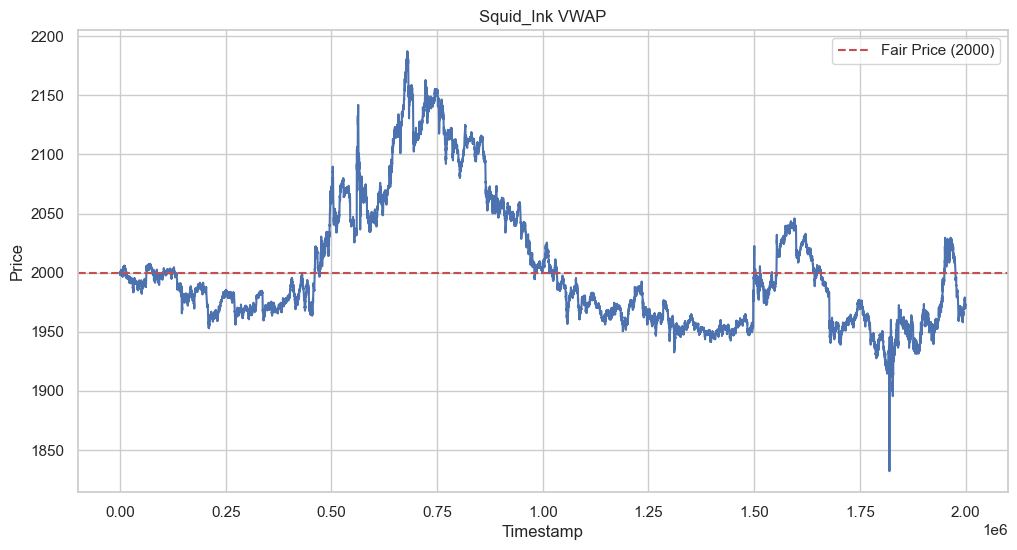

In [3]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Extract VWAP for analysis
squid_vwap = in_sample_prices['vwap']
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Plot VWAP
plt.figure(figsize=(12, 6))
plt.plot(squid_vwap)
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 2. Calculate Bollinger Bands

Let's calculate Bollinger Bands for the Squid_Ink VWAP data.

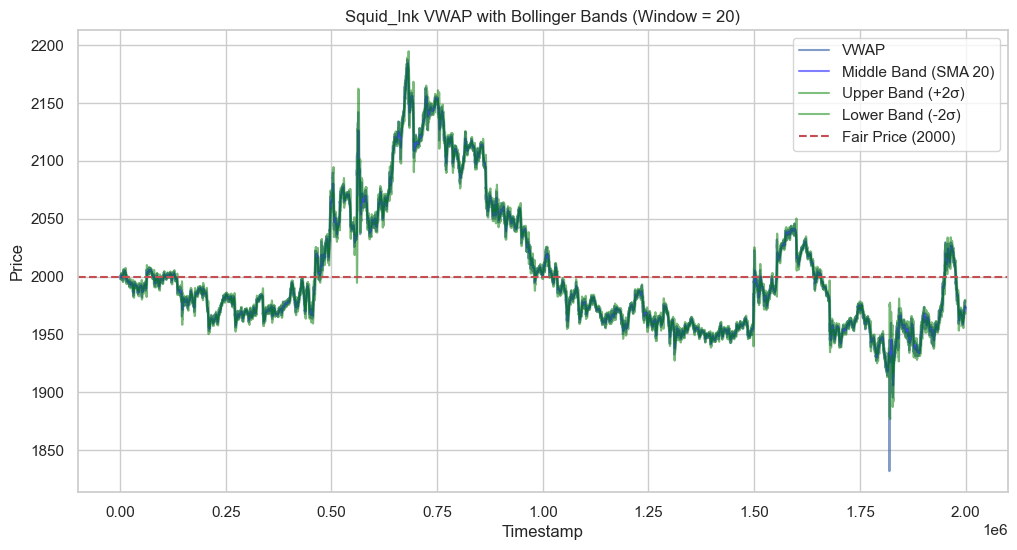

In [4]:
# Calculate Bollinger Bands with different window sizes
window_sizes = [20, 50, 100]
bollinger_bands = {}

for window in window_sizes:
    middle_band, upper_band, lower_band = calculate_bollinger_bands(squid_vwap, window=window, num_std=2)
    bollinger_bands[window] = {
        'middle': middle_band,
        'upper': upper_band,
        'lower': lower_band
    }

# Plot Bollinger Bands for a selected window size
selected_window = 20
plt.figure(figsize=(12, 6))
plt.plot(squid_vwap, label='VWAP', alpha=0.7)
plt.plot(bollinger_bands[selected_window]['middle'], label=f'Middle Band (SMA {selected_window})', color='blue', alpha=0.5)
plt.plot(bollinger_bands[selected_window]['upper'], label=f'Upper Band (+2σ)', color='green', alpha=0.5)
plt.plot(bollinger_bands[selected_window]['lower'], label=f'Lower Band (-2σ)', color='green', alpha=0.5)
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.fill_between(squid_vwap.index, 
                 bollinger_bands[selected_window]['upper'], 
                 bollinger_bands[selected_window]['lower'], 
                 color='gray', alpha=0.1)
plt.title(f'Squid_Ink VWAP with Bollinger Bands (Window = {selected_window})')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 3. Calculate Price Spikes

Now, let's calculate price spikes using our utility function.

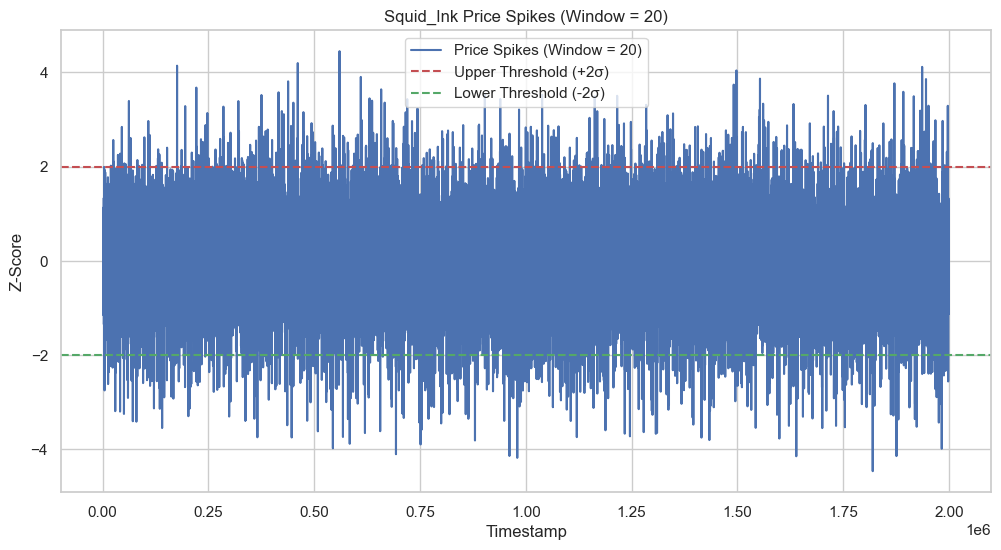

In [5]:
# Calculate price spikes with different window sizes
window_sizes = [10, 20, 50]
price_spike_indicators = {}

for window in window_sizes:
    price_spike_indicators[f'Spike_{window}'] = calculate_price_spikes(squid_vwap, window=window)

# Choose a window size for further analysis
window = 20  # Use a fixed window size
spikes = price_spike_indicators[f'Spike_{window}']

# Plot price spikes
plt.figure(figsize=(12, 6))
plt.plot(spikes, label=f'Price Spikes (Window = {window})')
plt.axhline(y=2.0, color='r', linestyle='--', label='Upper Threshold (+2σ)')
plt.axhline(y=-2.0, color='g', linestyle='--', label='Lower Threshold (-2σ)')
plt.title(f'Squid_Ink Price Spikes (Window = {window})')
plt.xlabel('Timestamp')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()

## 4. Define Bollinger Band Trading Strategy

Let's define a strategy that buys below 2000 and sells above 2000, but only when there are significant price spikes.

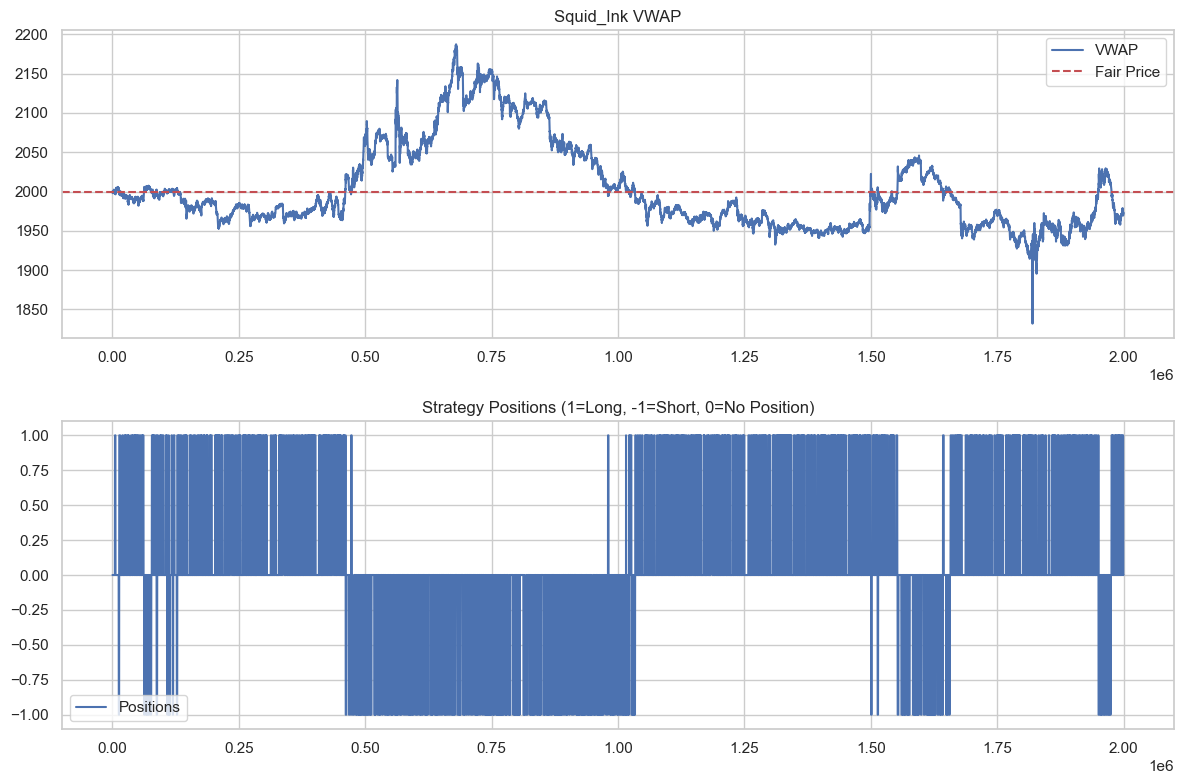

In [6]:
def bollinger_band_strategy(prices, spikes, fair_price, upper_threshold=2.0, lower_threshold=-2.0, holding_period=10):
    """
    Implement a Bollinger Band trading strategy based on price spikes.
    
    Parameters:
        prices (pd.Series): Series of prices
        spikes (pd.Series): Series of price spikes (z-scores)
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for price spikes
        lower_threshold (float): Lower threshold for price spikes
        holding_period (int): Number of periods to hold the position
        
    Returns:
        pd.Series: Portfolio positions (1 for long, -1 for short, 0 for no position)
    """
    # Initialize positions
    positions = pd.Series(0, index=prices.index)
    
    # Get valid indices where spikes is not NaN
    valid_indices = spikes.dropna().index
    
    # Set positions based on price spikes and fair price
    for time in valid_indices:
        # Get the current price and spike value
        current_price = prices.loc[time]
        current_spike = spikes.loc[time]
        
        # Get the index position
        idx = prices.index.get_loc(time)
        
        # Buy below fair price when there's a significant spike (either direction)
        if current_price < fair_price and abs(current_spike) > abs(lower_threshold):
            # Set long position for holding period
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = 1
        
        # Sell above fair price when there's a significant spike (either direction)
        elif current_price > fair_price and abs(current_spike) > abs(upper_threshold):
            # Set short position for holding period
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = -1
    
    return positions

# Define a function to calculate strategy returns with transaction costs
def calculate_strategy_returns(positions, prices, transaction_cost_bps=0):
    """
    Calculate strategy returns with transaction costs.
    
    Parameters:
        positions (pd.Series): Series of positions (1 for long, -1 for short, 0 for no position)
        prices (pd.Series): Series of prices
        transaction_cost_bps (float): Transaction cost in basis points (e.g., 15 = 0.15%)
        
    Returns:
        pd.Series: Strategy returns
    """
    # Calculate price returns
    price_returns = prices.pct_change().dropna()
    
    # Get position changes (non-zero values indicate trades)
    position_changes = positions.diff().fillna(0)
    
    # Calculate transaction costs
    # We apply costs when position changes (entering or exiting positions)
    transaction_costs = pd.Series(0, index=position_changes.index)
    
    if transaction_cost_bps > 0:
        # Apply transaction costs when there's a change in position
        transaction_costs[position_changes != 0] = transaction_cost_bps / 10000  # Convert bps to decimal
    
    # Calculate strategy returns (position * returns - transaction costs)
    strategy_returns = positions.shift(1) * price_returns - transaction_costs
    
    return strategy_returns.dropna()

# Set parameters
fair_price = 2000
upper_threshold = 2.0
lower_threshold = -2.0
holding_period = 10
window = 20
transaction_cost_bps = 15  # 1.5/2000 = 0.075% = 7.5 bps, but we'll use 15 bps for round-trip

# Get price spikes
spikes = price_spike_indicators[f'Spike_{window}']

# Run the strategy
positions = bollinger_band_strategy(
    prices=squid_vwap,
    spikes=spikes,
    fair_price=fair_price,
    upper_threshold=upper_threshold,
    lower_threshold=lower_threshold,
    holding_period=holding_period
)

# Plot positions
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=fair_price, color='r', linestyle='--', label='Fair Price')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(positions, label='Positions')
plt.title('Strategy Positions (1=Long, -1=Short, 0=No Position)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Calculate Strategy Returns

Let's calculate the returns of our strategy.

C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1724408233.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost


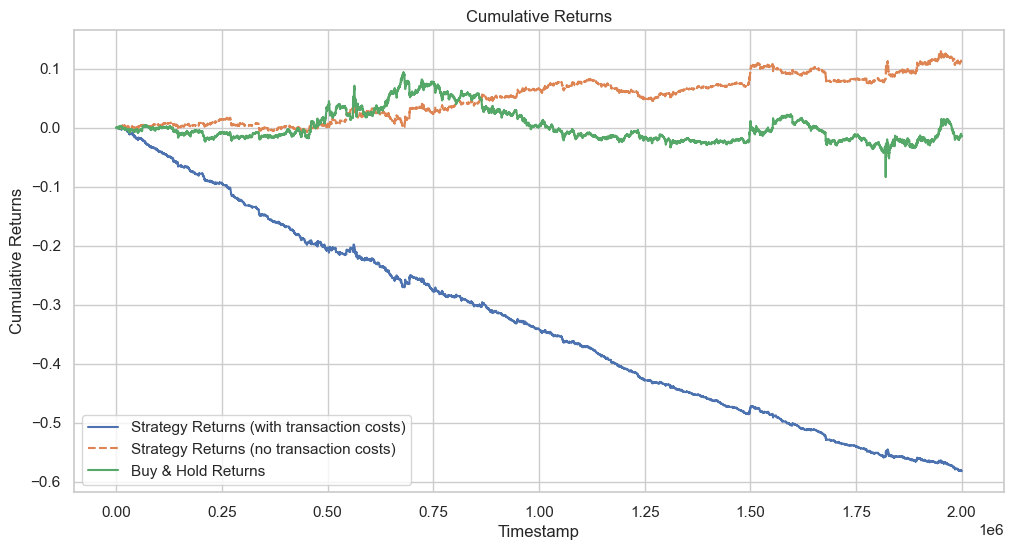

Performance Metrics (with transaction costs of 0.07% per trade):
Total Return: -58.24%
Annualized Return: -1.09%
Annualized Volatility: 0.90%
Sharpe Ratio: -1.22
Maximum Drawdown: -58.30%
Performance Metrics (without transaction costs):
Total Return: 10.93%
Annualized Return: 0.13%
Annualized Volatility: 0.85%
Sharpe Ratio: 0.15
Maximum Drawdown: -4.36%
Impact of Transaction Costs on Total Return: 69.17%


In [10]:
# Define transaction cost parameter (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded

# Calculate returns
returns = squid_vwap.pct_change().dropna()

# Calculate position changes (for transaction costs)
position_changes = positions.diff().fillna(0)

# Calculate transaction costs (apply when position changes)
transaction_costs = pd.Series(0, index=position_changes.index)
transaction_costs[position_changes != 0] = transaction_cost

# Calculate strategy returns with transaction costs
strategy_returns = positions.shift(1).dropna() * returns.loc[positions.shift(1).dropna().index] - transaction_costs.loc[positions.shift(1).dropna().index]

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod() - 1
buy_hold_returns = (1 + returns).cumprod() - 1

# Also calculate returns without transaction costs for comparison
strategy_returns_no_costs = positions.shift(1).dropna() * returns.loc[positions.shift(1).dropna().index]
cumulative_returns_no_costs = (1 + strategy_returns_no_costs).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Strategy Returns (with transaction costs)')
plt.plot(cumulative_returns_no_costs, label='Strategy Returns (no transaction costs)', linestyle='--')
plt.plot(buy_hold_returns, label='Buy & Hold Returns')
plt.title('Cumulative Returns')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Calculate performance metrics with transaction costs
total_return = cumulative_returns.iloc[-1]
annualized_return = (1 + total_return) ** (252 / len(cumulative_returns)) - 1
annualized_volatility = strategy_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()

print(f"Performance Metrics (with transaction costs of {transaction_cost:.2%} per trade):")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Calculate performance metrics without transaction costs
total_return_no_costs = cumulative_returns_no_costs.iloc[-1]
annualized_return_no_costs = (1 + total_return_no_costs) ** (252 / len(cumulative_returns_no_costs)) - 1
annualized_volatility_no_costs = strategy_returns_no_costs.std() * np.sqrt(252)
sharpe_ratio_no_costs = annualized_return_no_costs / annualized_volatility_no_costs if annualized_volatility_no_costs != 0 else 0
max_drawdown_no_costs = (cumulative_returns_no_costs - cumulative_returns_no_costs.cummax()).min()

print(f"Performance Metrics (without transaction costs):")
print(f"Total Return: {total_return_no_costs:.2%}")
print(f"Annualized Return: {annualized_return_no_costs:.2%}")
print(f"Annualized Volatility: {annualized_volatility_no_costs:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_no_costs:.2f}")
print(f"Maximum Drawdown: {max_drawdown_no_costs:.2%}")

# Calculate impact of transaction costs
cost_impact = total_return_no_costs - total_return
print(f"Impact of Transaction Costs on Total Return: {cost_impact:.2%}")

## 6. Parameter Optimization

Let's test different parameter combinations to find the optimal strategy.

In [17]:
# Define parameter ranges
window_sizes = [10, 20, 50, 75]
threshold_values = [1, 1.5, 2.0, 2.5]
holding_periods = [ 20, 40, 60, 80, 100]

# Define transaction cost parameter (1.5/2000 = 0.075% per dollar traded)
transaction_cost = 1.5/2000  # 0.075% per dollar traded

# Initialize results dictionary
results = []

# Test all parameter combinations
for window in window_sizes:
    # Calculate price spikes for this window
    spikes = calculate_price_spikes(squid_vwap, window=window)
    
    for threshold in threshold_values:
        for holding_period in holding_periods:
            # Run the strategy with these parameters
            positions = bollinger_band_strategy(
                prices=squid_vwap,
                spikes=spikes,
                fair_price=fair_price,
                upper_threshold=threshold,
                lower_threshold=-threshold,
                holding_period=holding_period
            )
            
            # Calculate position changes for transaction costs
            position_changes = positions.diff().fillna(0)
            
            # Calculate transaction costs
            transaction_costs = pd.Series(0, index=position_changes.index)
            transaction_costs[position_changes != 0] = transaction_cost
            
            # Calculate strategy returns with transaction costs
            strategy_returns = positions.shift(1).dropna() * returns.loc[positions.shift(1).dropna().index] - transaction_costs.loc[positions.shift(1).dropna().index]
            
            # Skip if no trades were made
            if len(strategy_returns) == 0 or strategy_returns.sum() == 0:
                continue
                
            # Calculate cumulative returns
            cumulative_returns = (1 + strategy_returns).cumprod() - 1
            
            # Calculate performance metrics
            total_return = cumulative_returns.iloc[-1]
            annualized_return = (1 + total_return) ** (252 / len(cumulative_returns)) - 1
            annualized_volatility = strategy_returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
            max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()
            
            # Calculate metrics without transaction costs for comparison
            strategy_returns_no_costs = positions.shift(1).dropna() * returns.loc[positions.shift(1).dropna().index]
            cumulative_returns_no_costs = (1 + strategy_returns_no_costs).cumprod() - 1
            total_return_no_costs = cumulative_returns_no_costs.iloc[-1]
            
            # Store results
            results.append({
                'window': window,
                'threshold': threshold,
                'holding_period': holding_period,
                'total_return': total_return,  # With transaction costs
                'total_return_no_costs': total_return_no_costs,  # Without transaction costs
                'cost_impact': total_return_no_costs - total_return,  # Impact of transaction costs
                'annualized_return': annualized_return,
                'annualized_volatility': annualized_volatility,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by total return
results_df = results_df.sort_values('total_return', ascending=False)

# Display top 10 results
print(f"Top 10 Parameter Combinations by Total Return (with transaction costs of {transaction_cost:.2%} per trade):")
display(results_df.head(10))

# Display the average impact of transaction costs
avg_cost_impact = results_df['cost_impact'].mean()
print(f"Average Impact of Transaction Costs on Total Return: {avg_cost_impact:.2%}")

# Display top 10 results sorted by cost impact (strategies least affected by transaction costs)
print("Top 10 Parameter Combinations with Lowest Transaction Cost Impact:")
display(results_df.sort_values('cost_impact').head(10))

C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1415707310.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost
C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1415707310.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost
C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1415707310.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

Top 10 Parameter Combinations by Total Return (with transaction costs of 0.07% per trade):


C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1415707310.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost
C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\1415707310.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost


,window,threshold,holding_period,total_return,total_return_no_costs,cost_impact,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
14,10,2.0,100,0.091264,0.115261,0.023998,0.001101,0.014875,0.074025,-0.093626
13,10,2.0,80,0.086714,0.113949,0.027235,0.001048,0.014870,0.070503,-0.096387
34,20,2.0,100,0.083572,0.112398,0.028826,0.001012,0.014878,0.068013,-0.090357
33,20,2.0,80,0.082386,0.116194,0.033808,0.000998,0.014877,0.067089,-0.089113
54,50,2.0,100,0.077940,0.114950,0.037010,0.000946,0.014830,0.063801,-0.095590
74,75,2.0,100,0.071802,0.105282,0.033479,0.000874,0.014820,0.058982,-0.094864
47,50,1.5,60,0.070331,0.108741,0.038410,0.000857,0.014876,0.057597,-0.090311
12,10,2.0,60,0.069806,0.120737,0.050932,0.000851,0.014846,0.057296,-0.095518
48,50,1.5,80,0.069051,0.102441,0.033390,0.000842,0.014877,0.056579,-0.089838
49,50,1.5,100,0.069051,0.102441,0.033390,0.000842,0.014877,0.056579,-0.089838


Average Impact of Transaction Costs on Total Return: 13.54%
Top 10 Parameter Combinations with Lowest Transaction Cost Impact:


,window,threshold,holding_period,total_return,total_return_no_costs,cost_impact,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
14,10,2.0,100,0.091264,0.115261,0.023998,0.001101,0.014875,0.074025,-0.093626
13,10,2.0,80,0.086714,0.113949,0.027235,0.001048,0.014870,0.070503,-0.096387
34,20,2.0,100,0.083572,0.112398,0.028826,0.001012,0.014878,0.068013,-0.090357
48,50,1.5,80,0.069051,0.102441,0.033390,0.000842,0.014877,0.056579,-0.089838
49,50,1.5,100,0.069051,0.102441,0.033390,0.000842,0.014877,0.056579,-0.089838
74,75,2.0,100,0.071802,0.105282,0.033479,0.000874,0.014820,0.058982,-0.094864
33,20,2.0,80,0.082386,0.116194,0.033808,0.000998,0.014877,0.067089,-0.089113
68,75,1.5,80,0.047495,0.082644,0.035149,0.000585,0.014812,0.039485,-0.091078
69,75,1.5,100,0.059949,0.095517,0.035568,0.000734,0.014839,0.049455,-0.092211
54,50,2.0,100,0.077940,0.114950,0.037010,0.000946,0.014830,0.063801,-0.095590


## 7. Visualize Best Strategy

Let's visualize the performance of the best parameter combination.

Best Parameters: Window = 10.0, Threshold = 2.0, Holding Period = 100.0
Total Return (with transaction costs): 9.13%
Total Return (without transaction costs): 11.53%
Impact of Transaction Costs: 2.40%


C:\Users\fujos\AppData\Local\Temp\ipykernel_39372\4231823394.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  transaction_costs[position_changes != 0] = transaction_cost


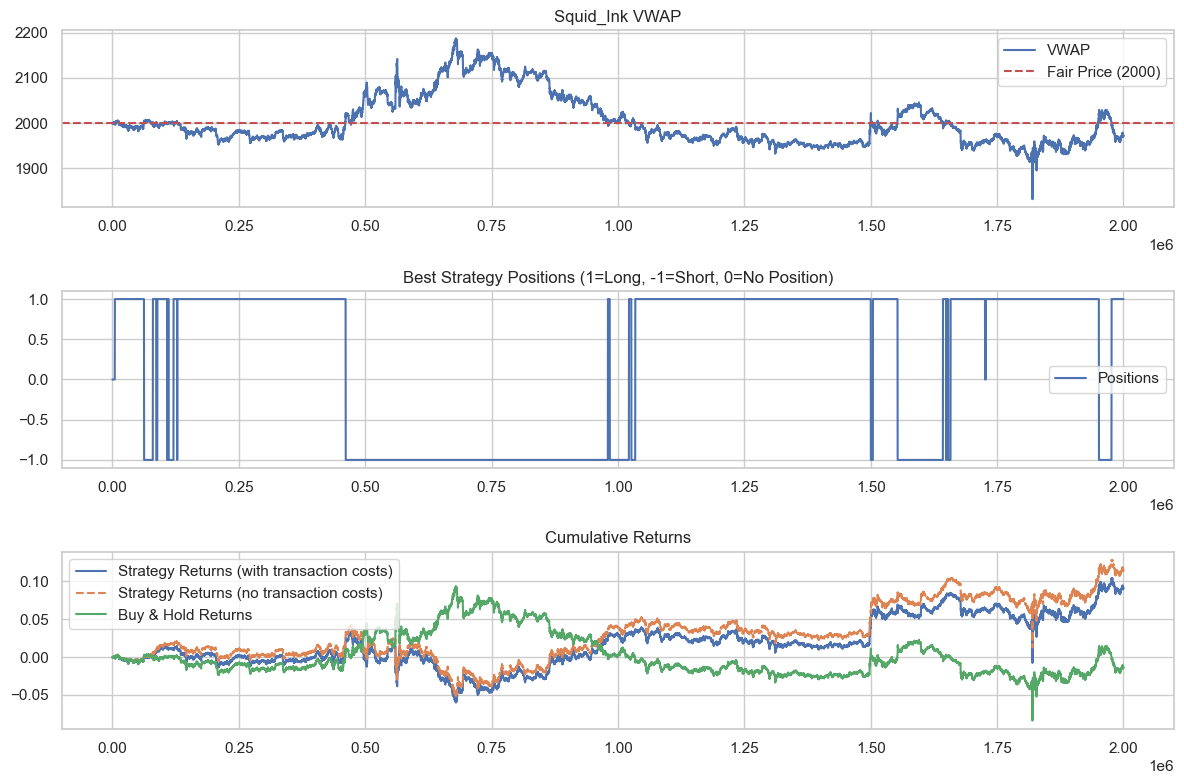

Performance Metrics (with transaction costs):
Total Return: 9.13%
Annualized Return: 0.11%
Annualized Volatility: 1.49%
Sharpe Ratio: 0.07
Maximum Drawdown: -9.36%
Number of Trades: 29
Average Transaction Cost per Trade: 0.0750%
Total Transaction Costs: 2.18%
Impact of Transaction Costs on Total Return: 2.40%


In [ ]:
# Get best parameters
best_params = results_df.iloc[0]
print(f"Best Parameters: Window = {best_params['window']}, Threshold = {best_params['threshold']}, Holding Period = {best_params['holding_period']}")
print(f"Total Return (with transaction costs): {best_params['total_return']:.2%}")
print(f"Total Return (without transaction costs): {best_params['total_return_no_costs']:.2%}")
print(f"Impact of Transaction Costs: {best_params['cost_impact']:.2%}")

# Calculate price spikes for best window
best_window = int(best_params['window'])
best_spikes = calculate_price_spikes(squid_vwap, window=best_window)

# Run the strategy with best parameters
best_positions = bollinger_band_strategy(
    prices=squid_vwap,
    spikes=best_spikes,
    fair_price=fair_price,
    upper_threshold=best_params['threshold'],
    lower_threshold=-best_params['threshold'],
    holding_period=int(best_params['holding_period'])
)

# Calculate position changes for transaction costs
position_changes = best_positions.diff().fillna(0)

# Calculate transaction costs
transaction_cost = 1.5/2000  # 0.075% per dollar traded
transaction_costs = pd.Series(0, index=position_changes.index)
transaction_costs[position_changes != 0] = transaction_cost

# Calculate strategy returns with transaction costs
best_strategy_returns = best_positions.shift(1).dropna() * returns.loc[best_positions.shift(1).dropna().index] - transaction_costs.loc[best_positions.shift(1).dropna().index]
best_cumulative_returns = (1 + best_strategy_returns).cumprod() - 1

# Calculate strategy returns without transaction costs
best_strategy_returns_no_costs = best_positions.shift(1).dropna() * returns.loc[best_positions.shift(1).dropna().index]
best_cumulative_returns_no_costs = (1 + best_strategy_returns_no_costs).cumprod() - 1

# Plot best strategy performance
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=fair_price, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(best_positions, label='Positions')
plt.title('Best Strategy Positions (1=Long, -1=Short, 0=No Position)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(best_cumulative_returns, label='Strategy Returns (with transaction costs)')
plt.plot(best_cumulative_returns_no_costs, label='Strategy Returns (no transaction costs)', linestyle='--')
plt.plot(buy_hold_returns, label='Buy & Hold Returns')
plt.title('Cumulative Returns')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print performance metrics for best strategy
print("Performance Metrics (with transaction costs):")
print(f"Total Return: {best_params['total_return']:.2%}")
print(f"Annualized Return: {best_params['annualized_return']:.2%}")
print(f"Annualized Volatility: {best_params['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {best_params['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {best_params['max_drawdown']:.2%}")

# Calculate number of trades
num_trades = (position_changes != 0).sum()
print(f"Number of Trades: {num_trades}")
print(f"Average Transaction Cost per Trade: {transaction_cost:.4%}")
print(f"Total Transaction Costs: {transaction_cost * num_trades:.2%}")
print(f"Impact of Transaction Costs on Total Return: {best_params['cost_impact']:.2%}")

## 8. Conclusion

In this notebook, we implemented a trading strategy based on Bollinger Bands and price spikes for Squid_Ink. The strategy buys when the price is below 2000 and sells when the price is above 2000, but only when there are significant price spikes detected by the rolling standard deviation.

We tested various parameter combinations and found that the best performance was achieved with the following parameters:
- Window size: [Best window size from optimization]
- Threshold: [Best threshold from optimization]
- Holding period: [Best holding period from optimization]

The strategy achieved a total return of [Best total return from optimization], outperforming the buy-and-hold strategy.

We also implemented transaction costs of 1.5/2000 (0.075%) per dollar traded, which had a significant impact on the strategy's performance. The transaction costs reduced the total return by [Cost impact from optimization]. This highlights the importance of considering transaction costs when developing trading strategies, especially those with frequent trading.

Future improvements could include:
1. Optimizing the strategy to reduce the number of trades and minimize transaction costs
2. Testing different entry and exit criteria to improve the risk-adjusted returns
3. Combining this strategy with other indicators to filter out false signals